# NRWC Workshop

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import statsmodels.api as sm
from scipy import stats, special
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.special import gammaincc
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import cochrans_q
from statsmodels.stats.contingency_tables import mcnemar
from typing import Dict, List, Optional

import helper_functions as hf  # Custom helper functions

# Use autoreload to automatically reload changes from the Python file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Online survey results

In [22]:
# Load data from the first sheet of an Excel file

# Read the CSV file into a DataFrame
df_survey = pd.read_csv("data/nrwc2024-survey_V3.csv")

df_survey

,id,What is your profession/main occupation?,What is your age?,Gender,"If in-store music is played, I would prefer the music to be human-made rather than AI-generated",I prefer in-store music rather than a silent shopping environment,I prefer highly personalized in-store music,"When facing a choice between maximum privacy and minimum personalization and minimum privacy and maximum personalization, what would you prefer?",I prefer not to share data about myself or my musical taste to companies,Submitted At
0,aevi7kwyoc,Student,21,Male,I strongly prefer human-made,I prefer music,I am neutral,"moderate privacy, moderate personalization",I strongly agree,"Nov 06, 2024 03:30 pm"
1,1vyih1icof,Researcher,46,Female,I am neutral,I slightly prefer silence,I am neutral,"moderate privacy, moderate personalization",I strongly disagree,"Nov 06, 2024 03:29 pm"
2,qr02k9yi00,Student,21,Female,I strongly prefer human-made,I slightly prefer music,I am neutral,"moderate privacy, moderate personalization",I slightly agree,"Nov 06, 2024 03:26 pm"
3,689hc3eirj,Economist,39,Male,I prefer human-made,I prefer music,Strongly agree,"very high privacy, very low personalization",I strongly agree,"Nov 06, 2024 03:25 pm"
4,in6e5zeavl,Student + part time work,24,Female,I am neutral,I prefer music,Agree,"moderate privacy, moderate personalization",I strongly disagree,"Nov 06, 2024 03:25 pm"
5,xqzddqp0gi,Student,20,Male,I am neutral,I prefer music,Slightly agree,"very high privacy, very low personalization",I disagree,"Nov 06, 2024 03:24 pm"
6,sviil6zpyl,Student,21,Male,I slightly prefer human-made,I prefer music,I am neutral,"high privacy, low personalization",I slightly disagree,"Nov 06, 2024 03:24 pm"
7,reqvki6dp4,Student,23,Female,I strongly prefer human-made,I strongly prefer music,Slightly agree,"moderate privacy, moderate personalization",I agree,"Nov 06, 2024 03:24 pm"
8,kpuu82kx9u,Researcher,39,Male,I strongly prefer human-made,I slightly prefer music,Slightly agree,"moderate privacy, moderate personalization",I slightly agree,"Nov 06, 2024 02:49 pm"
9,6oxze1ix3w,Researcher,30,Male,I am neutral,I prefer music,I am neutral,"maximum privacy, minimum personalization",I slightly disagree,"Nov 06, 2024 02:34 pm"


In [23]:
# Create a mask for rows to keep
mask = (df_survey['id'] != 'fi3trcsuvu') & (df_survey['id'] != 'xerby9dknu')

# Filter the DataFrame using the mask
df_survey_filtered = df_survey[mask]

new_column_names = ['id', 'Occupation', 'Age', 'Gender', 'Human_or_AI_music', 'Music_or_silence', 'Personalized_music', 'Privacy_vs_personalization', 'Sharing_data', 'Time']
df_survey_filtered.columns = new_column_names
df_survey_filtered

print('Total number of participants: ', df_survey_filtered['id'].nunique()) 

Total number of participants:  21


In [24]:
# Assuming your DataFrame is named 'df'
columns_to_plot = df_survey_filtered.columns[4:9] 
#df_survey_filtered[columns_to_plot]

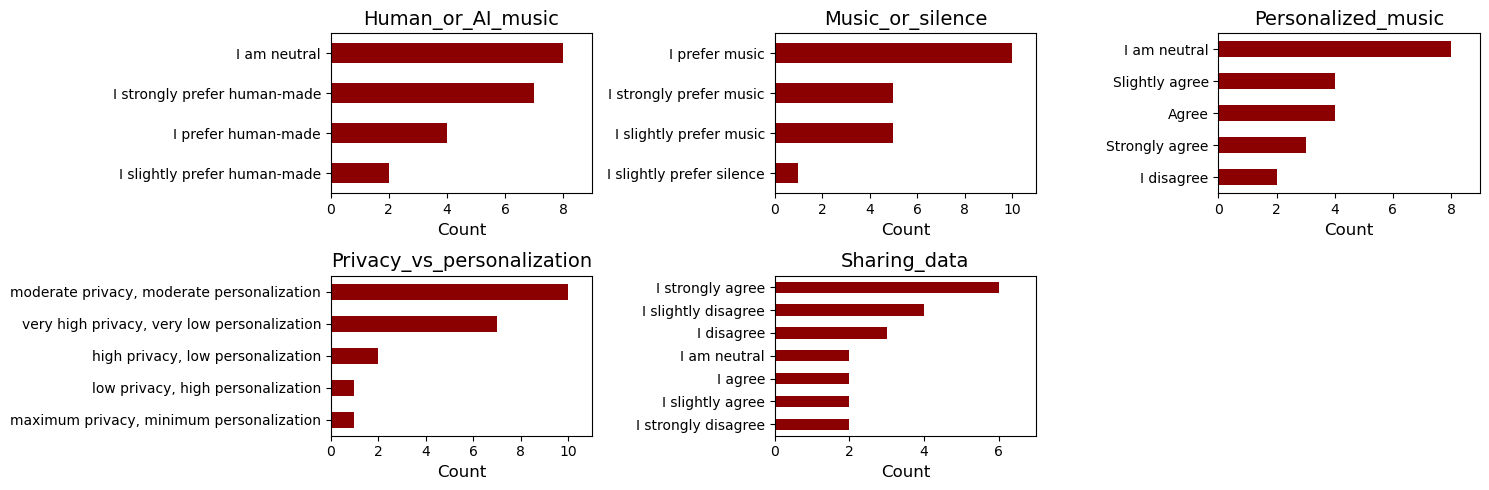

In [25]:
if not os.path.exists('plots/survey'):
    os.makedirs('plots/survey')

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))  # Adjust figsize as needed

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over columns and plot in separate subplots
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    value_counts = df_survey_filtered[col].value_counts().sort_values(ascending=True)
    value_counts.plot(kind='barh', ax=ax, color='darkred')

    ax.set_xlabel('Count', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    ax.set_title(f'{col}', fontsize=14)
    ax.set_xticks(range(0, int(value_counts.max()) + 1, 2))
    ax.set_xlim(0, int(value_counts.max()) + 1)

# Remove any extra subplots (if necessary)
for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
# Save the figure
plt.savefig('plots/survey/survey_results.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

In [26]:
df_survey_filtered[['Human_or_AI_music']].value_counts().sum()

21

In [27]:
df_survey_filtered[df_survey_filtered.columns[4:9]].describe() 

,Human_or_AI_music,Music_or_silence,Personalized_music,Privacy_vs_personalization,Sharing_data
count,21,21,21,21,21
unique,4,4,5,5,7
top,I am neutral,I prefer music,I am neutral,"moderate privacy, moderate personalization",I strongly agree
freq,8,10,8,10,6


## Read file from XLS 
Input quiz results here. 
Please note: 
- Replies are not mandatory for all cells - there can be empty cells 
- Every row corresponds to a participant (here called 'Voter')
- From the room it looks like there are 6 participants 

In [28]:
# Load data from the first sheet of an Excel file
df = pd.read_excel('data/NRWC-quiz_V2.xlsx', sheet_name='Voters', usecols='A:O', skiprows=2)
df

,Date,Session,Voter,:,:.1,:.2,:.3,:.4,:.5,:.6,:.7,:.8,:.9,:.10,:.11
0,2024-11-05,1,1,Åhlens,Naturkompaniet,XS Leker,Kappahl,Stadium,Cubus,Naturkompaniet,NaN,NaN,NaN,NaN,NaN
1,2024-11-05,2,2,Naturkompaniet,XS Leker,Stadium,Åhlens,Cubus,Kappahl,Stadium,Kappahl,XS Leker,Stadium,Naturkompaniet,Kappahl
2,2024-11-05,2,3,Kappahl,NaN,Stadium,Cubus,Åhlens,XS Leker,Stadium,Cubus,Kappahl,XS Leker,Åhlens,Stadium
3,2024-11-05,2,4,Kappahl,Naturkompaniet,XS Leker,Stadium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-11-06,3,5,Åhlens,Kappahl,Åhlens,Åhlens,Naturkompaniet,XS Leker,Cubus,Cubus,Naturkompaniet,Åhlens,Naturkompaniet,Stadium
5,2024-11-06,3,6,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,XS Leker,Åhlens,Cubus,Naturkompaniet,Kappahl,Stadium
6,2024-11-06,3,7,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Naturkompaniet,Åhlens,Åhlens,Kappahl
7,2024-11-06,3,8,Åhlens,Cubus,Kappahl,Kappahl,Naturkompaniet,XS Leker,Cubus,XS Leker,Kappahl,Åhlens,Naturkompaniet,Stadium
8,2024-11-06,3,9,XS Leker,Kappahl,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Åhlens,Naturkompaniet,Kappahl,Stadium
9,2024-11-06,3,10,XS Leker,Kappahl,Kappahl,Cubus,Naturkompaniet,Åhlens,XS Leker,Åhlens,Stadium,Cubus,Naturkompaniet,Kappahl


### Filter on session (if necessary)

In [29]:
# Filtering and cleaning the DataFrame
# If required to filter on session, specify session number here 
#mask = df['Session'] == 2
#filtered_df = df[mask]

# If filtering on day is required 
mask_date = df['Date'] == '2024-11-06'
filtered_df_date = df[mask_date]

filtered_df_date

,Date,Session,Voter,:,:.1,:.2,:.3,:.4,:.5,:.6,:.7,:.8,:.9,:.10,:.11
4,2024-11-06,3,5,Åhlens,Kappahl,Åhlens,Åhlens,Naturkompaniet,XS Leker,Cubus,Cubus,Naturkompaniet,Åhlens,Naturkompaniet,Stadium
5,2024-11-06,3,6,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,XS Leker,Åhlens,Cubus,Naturkompaniet,Kappahl,Stadium
6,2024-11-06,3,7,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Naturkompaniet,Åhlens,Åhlens,Kappahl
7,2024-11-06,3,8,Åhlens,Cubus,Kappahl,Kappahl,Naturkompaniet,XS Leker,Cubus,XS Leker,Kappahl,Åhlens,Naturkompaniet,Stadium
8,2024-11-06,3,9,XS Leker,Kappahl,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Åhlens,Naturkompaniet,Kappahl,Stadium
9,2024-11-06,3,10,XS Leker,Kappahl,Kappahl,Cubus,Naturkompaniet,Åhlens,XS Leker,Åhlens,Stadium,Cubus,Naturkompaniet,Kappahl
10,2024-11-06,3,11,Åhlens,Kappahl,Cubus,Åhlens,Naturkompaniet,XS Leker,NaN,XS Leker,Åhlens,Stadium,Cubus,Åhlens
11,2024-11-06,3,12,Cubus,Kappahl,Kappahl,Åhlens,XS Leker,XS Leker,XS Leker,Cubus,Stadium,Kappahl,Åhlens,Åhlens
12,2024-11-06,3,13,Åhlens,Stadium,Kappahl,Kappahl,Naturkompaniet,XS Leker,Cubus,Kappahl,Åhlens,Naturkompaniet,Stadium,Naturkompaniet
13,2024-11-06,3,14,Åhlens,Stadium,Kappahl,Kappahl,Naturkompaniet,XS Leker,XS Leker,Åhlens,Naturkompaniet,Naturkompaniet,Kappahl,Cubus


In [30]:
# Rename columns from the 3rd column onward to 'Q1' to 'Q12'
new_column_names = {df.columns[i]: f"Q{i - 2}" for i in range(3, 15)}  # Adjust range as needed
df.rename(columns=new_column_names, inplace=True)
df.head()

# Check data types for columns 
print(df.dtypes)
df.info()

Date       object
Session     int64
Voter       int64
Q1         object
Q2         object
Q3         object
Q4         object
Q5         object
Q6         object
Q7         object
Q8         object
Q9         object
Q10        object
Q11        object
Q12        object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     18 non-null     object
 1   Session  18 non-null     int64 
 2   Voter    18 non-null     int64 
 3   Q1       18 non-null     object
 4   Q2       17 non-null     object
 5   Q3       18 non-null     object
 6   Q4       18 non-null     object
 7   Q5       17 non-null     object
 8   Q6       17 non-null     object
 9   Q7       16 non-null     object
 10  Q8       16 non-null     object
 11  Q9       16 non-null     object
 12  Q10      16 non-null     object
 13  Q11      16 non-null     object
 14  Q12      16 non-

In [31]:
#Descriptive statistics for categorical columns
category_stats = df[df.columns[3:]].describe(include='object')

# Calculate missing values per column
missing_counts = df[df.columns[3:]].isnull().sum()

# Add the missing values count as a new row to the descriptive statistics DataFrame
category_stats.loc['NaN'] = missing_counts

print("Descriptive statistics for each question:")
category_stats

#freq: The number of times the most frequent category (from the top value) appears in that column.

Descriptive statistics for each question:


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
count,18,17,18,18,17,17,16,16,16,16,16,16
unique,5,5,6,4,5,4,5,4,6,6,5,5
top,Åhlens,Kappahl,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Åhlens,Åhlens,Naturkompaniet,Stadium
freq,11,6,11,7,12,13,6,8,4,6,7,7
NaN,0,1,0,0,1,1,2,2,2,2,2,2


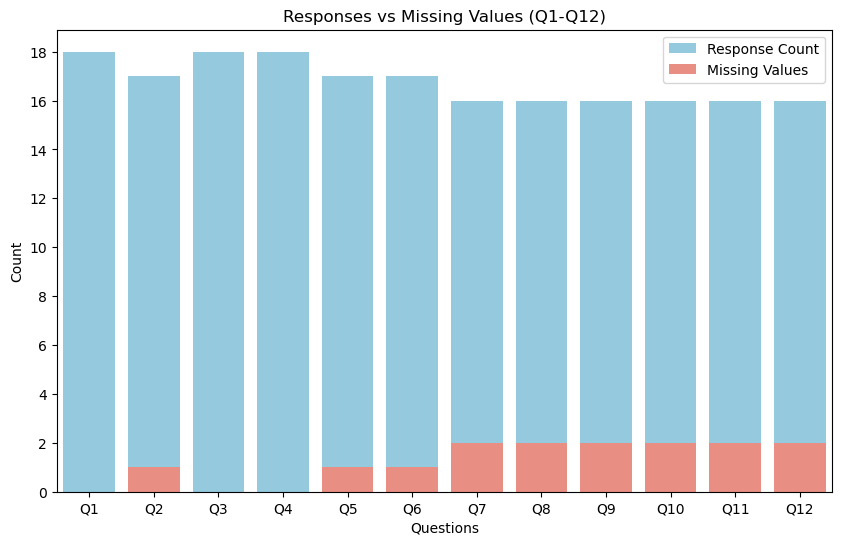

In [32]:
# Plot counts and missing values
plt.figure(figsize=(10, 6))
ax = plt.gca()  
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True)) # Make sure y axis has only integers, since it shows counts  
sns.barplot(x=category_stats.columns, y=category_stats.loc['count'], color='skyblue', label='Response Count')
sns.barplot(x=missing_counts.index, y=missing_counts.values, color='salmon', label='Missing Values')
plt.title('Responses vs Missing Values (Q1-Q12)')
plt.xlabel('Questions')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
# Define the correct answers
correct_answers_dict = {
    'Q1': 'Åhlens image',
    'Q2': 'Stadium image',
    'Q3': 'Kappahl image',
    'Q4': 'Cubus image',
    'Q5': 'Naturkompaniet image',
    'Q6': 'XS Leker image',
    'Q7': 'Stadium sound',
    'Q8': 'XS Leker sound',
    'Q9': 'Kappahl sound',
    'Q10': 'Cubus sound',
    'Q11': 'Naturkompaniet sound',
    'Q12': 'Åhlens sound'
}
  
# Define a consistent color palette using the colorblind palette
colorblind_palette = sns.color_palette("colorblind", n_colors=len(df.columns[3:].unique()))

# Create a mapping of each store category to a color
unique_categories = df[df.columns[3:]].melt()['value'].dropna().unique() 
color_map = {category: colorblind_palette[i] for i, category in enumerate(unique_categories)}

def ensure_directory(directory):
    """Create directory if it doesn't exist"""
    if not os.path.exists(directory):
        os.makedirs(directory)

def plot_and_save_questions(df, title, output_dir='plots/quiz'):
    # Create directory if it doesn't exist
    ensure_directory(output_dir)
    
    # Create main figure
    fig = plt.figure(figsize=(15, 8))
    # Count non-null values in each column and pick maximum 
    max_count = df.count().max() + 1  # Set max count for x-axis
    
    # Store individual plot data
    individual_plots = []
    
    for i, col in enumerate(df.columns, 1):
        # Create subplot in main figure
        ax = plt.subplot(3, 2, i)
        # Count occurrences of each response
        counts = df[col].value_counts()
        # Create a bar plot using counts
        counts = counts.reindex(unique_categories, fill_value=0)
        counts.plot(kind='barh', ax=ax, color=[color_map[category] for category in counts.index])
        
        subplot_title = f"{col}: {correct_answers_dict[col]}"
        plt.title(subplot_title, wrap=True, fontsize=14)  # Increased subplot title size
        plt.xlabel("Count", fontsize=12)  # Increased x-label size
        plt.ylabel("")
        ax.set_xlim(0, max_count)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # Increase tick label sizes
        ax.tick_params(axis='both', labelsize=12)
        
        # Increase legend font size
        #legend = ax.legend(fontsize=12)
        #legend.set_title("Response", prop={'size': 12})
        
        # Save individual subplot
        individual_fig = plt.figure(figsize=(8, 5))
        individual_ax = individual_fig.add_subplot(111)
        counts.plot(kind='barh', ax=individual_ax, color=[color_map[category] for category in counts.index])
        individual_ax.set_title(subplot_title, wrap=True, fontsize=14)  # Increased individual plot title size
        individual_ax.set_xlabel("Count", fontsize=12)  # Increased individual plot x-label size
        individual_ax.set_ylabel("")
        individual_ax.set_xlim(0, max_count)
        individual_ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # Increase tick label sizes for individual plots
        individual_ax.tick_params(axis='both', labelsize=12)
               
        # Save individual plot
        filename = f"{output_dir}/{col.lower()}_plot.png"
        individual_fig.tight_layout()
        individual_fig.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(individual_fig)
        
    # Finish and save main figure
    plt.figure(fig.number)
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=0.95)  # Increased main title size and adjusted position
    plt.subplots_adjust(top=0.9)
    
    # Save complete figure
    main_filename = f"{output_dir}/ind_{title.lower().replace(' ', '_').replace(':', '')}.png"
    plt.savefig(main_filename, dpi=300, bbox_inches='tight')
    plt.show()
  
# Plot and save Q1-Q6
df_images = df[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']]
plot_and_save_questions(df_images, "Images_Response_Counts_Q1-Q6")

# Plot and save Q7-Q12
df_sounds = df[['Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']]
plot_and_save_questions(df_sounds, "Sounds_Response_Counts_Q7-Q12")

print("All plots have been saved in the 'plots' directory!")

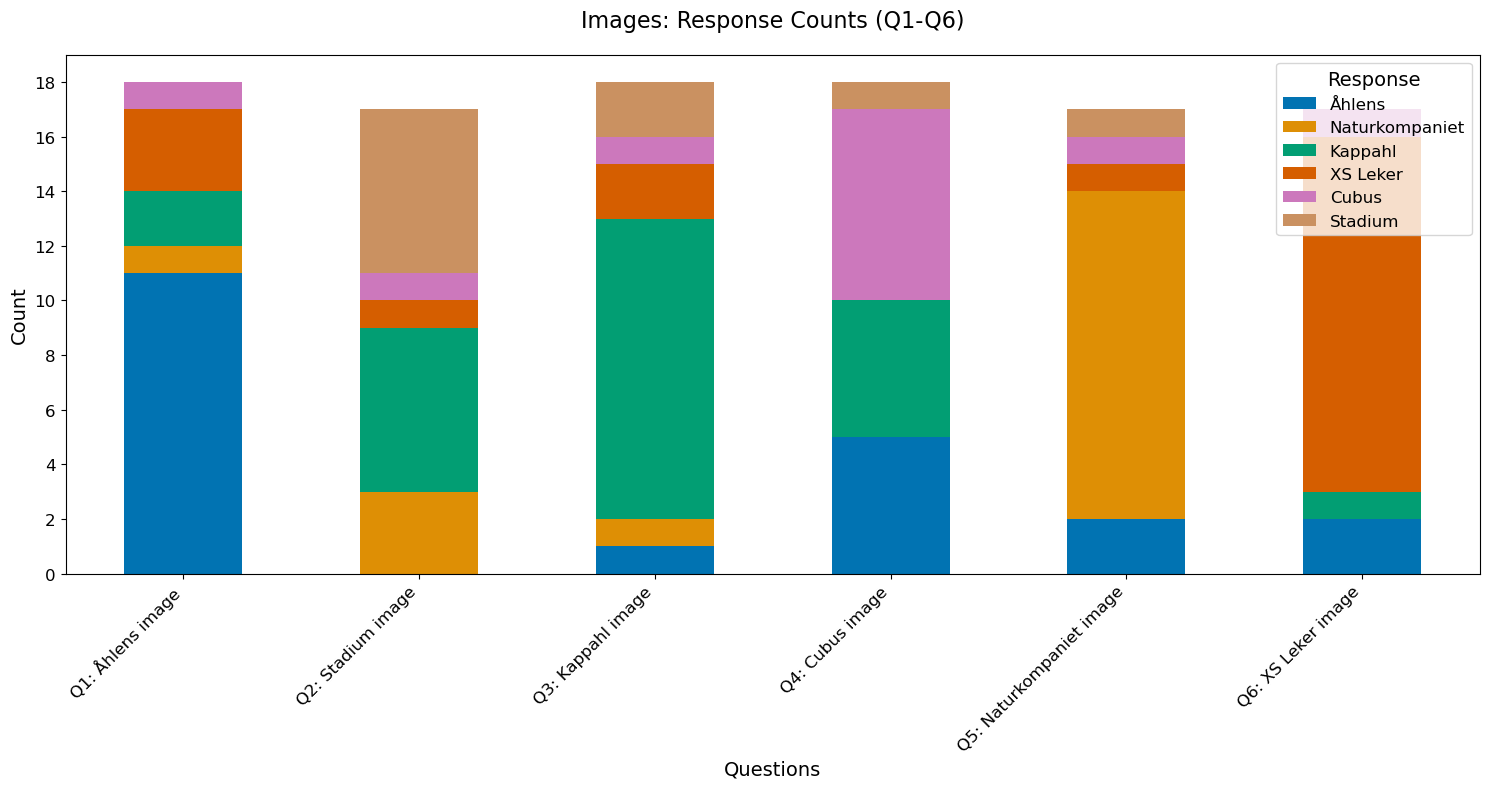

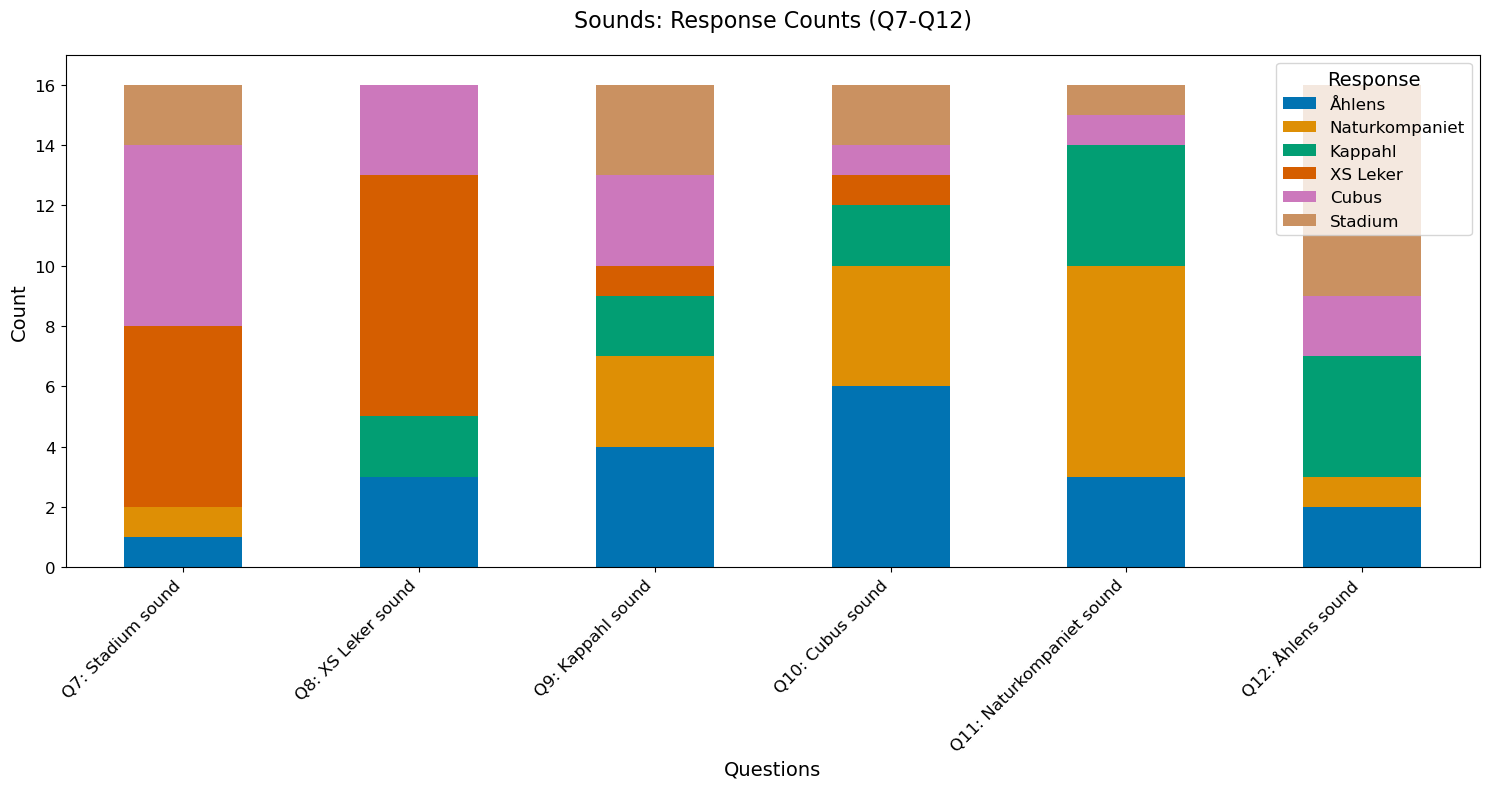

In [46]:
def plot_stacked_bar(df_subset, title, label_dict=correct_answers_dict, output_dir='plots/quiz'):
    # Create directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Calculate value counts for each question and fill NaNs with 0
    response_counts = df_subset.apply(pd.Series.value_counts).fillna(0).T
    response_counts = response_counts.reindex(columns=unique_categories, fill_value=0)
    
    # Create plot
    response_counts.plot(kind='bar', stacked=True, ax=ax, color=color_map.values())
    
    # Set title with larger font
    plt.title(title, fontsize=16, pad=20)
    
    # Set axis labels with larger font
    plt.xlabel("Questions", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    
    # Set x-axis labels combining question number and description
    x_labels = [f"{col}: {label_dict[col]}" for col in df_subset.columns]
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)  # Increased tick label size
    
    # Increase y-axis tick label size
    ax.tick_params(axis='y', labelsize=12)
    
    plt.ylim(0, response_counts.sum(axis=1).max() + 1)  # Set y-axis limit
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Only show integer ticks
    
    # Set legend with larger font
    plt.legend(title="Response", loc='upper right', fontsize=12)  # Increase legend text size
    ax.get_legend().set_title("Response", prop={'size': 14})  # Increase legend title size
    
    # Adjust layout and save
    plt.tight_layout()
    filename = f"{output_dir}/stacked_{title.lower().replace(' ', '_').replace(':', '')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

# Plot Q1-Q6
df_images = df[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']]
plot_stacked_bar(df_images, "Images: Response Counts (Q1-Q6)")

# Plot Q7-Q12
df_sounds = df[['Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']]
plot_stacked_bar(df_sounds, "Sounds: Response Counts (Q7-Q12)")

## Calculate number of correct replies per question 

## Correct answers 
### Q1-Q6: Images  
1. Åhlens 
2. Stadium 
3. Kappahl
4. Cubus
5. Naturkompaniet
6. XS Leker 

### Q7-Q12: Sounds
7. Stadium
8. XS Leksaker
9. Kappahl 
10. Cubus 
11. Naturkompaniet 
12. Åhlens 

In [35]:
# Define the correct answers
correct_answers = ['Åhlens', 'Stadium', 'Kappahl', 'Cubus', 'Naturkompaniet', 'XS Leker', 
                   'Stadium', 'XS Leker', 'Kappahl', 'Cubus', 'Naturkompaniet', 'Åhlens'
]
# Create a copy of the DataFrame to hold correct/incorrect responses
df_correct = df.copy()
df_correct

,Date,Session,Voter,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
0,2024-11-05,1,1,Åhlens,Naturkompaniet,XS Leker,Kappahl,Stadium,Cubus,Naturkompaniet,NaN,NaN,NaN,NaN,NaN
1,2024-11-05,2,2,Naturkompaniet,XS Leker,Stadium,Åhlens,Cubus,Kappahl,Stadium,Kappahl,XS Leker,Stadium,Naturkompaniet,Kappahl
2,2024-11-05,2,3,Kappahl,NaN,Stadium,Cubus,Åhlens,XS Leker,Stadium,Cubus,Kappahl,XS Leker,Åhlens,Stadium
3,2024-11-05,2,4,Kappahl,Naturkompaniet,XS Leker,Stadium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-11-06,3,5,Åhlens,Kappahl,Åhlens,Åhlens,Naturkompaniet,XS Leker,Cubus,Cubus,Naturkompaniet,Åhlens,Naturkompaniet,Stadium
5,2024-11-06,3,6,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,XS Leker,Åhlens,Cubus,Naturkompaniet,Kappahl,Stadium
6,2024-11-06,3,7,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Naturkompaniet,Åhlens,Åhlens,Kappahl
7,2024-11-06,3,8,Åhlens,Cubus,Kappahl,Kappahl,Naturkompaniet,XS Leker,Cubus,XS Leker,Kappahl,Åhlens,Naturkompaniet,Stadium
8,2024-11-06,3,9,XS Leker,Kappahl,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Åhlens,Naturkompaniet,Kappahl,Stadium
9,2024-11-06,3,10,XS Leker,Kappahl,Kappahl,Cubus,Naturkompaniet,Åhlens,XS Leker,Åhlens,Stadium,Cubus,Naturkompaniet,Kappahl


In [36]:
# Replace answers with 1 for correct and 0 for incorrect
for i in range(12):  # For Q1 to Q12
    # F-string syntax to dynamically create new column names 
    df_correct[f'Q{i+1}'] = df_correct[f'Q{i+1}'].apply(lambda x: 1 if x == correct_answers[i] else 0)

df_correct

,Date,Session,Voter,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
0,2024-11-05,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,2024-11-05,2,2,0,0,0,0,0,0,1,0,0,0,1,0
2,2024-11-05,2,3,0,0,0,1,0,1,1,0,1,0,0,0
3,2024-11-05,2,4,0,0,0,0,0,0,0,0,0,0,0,0
4,2024-11-06,3,5,1,0,0,0,1,1,0,0,0,0,1,0
5,2024-11-06,3,6,1,1,1,1,1,1,0,0,0,0,0,0
6,2024-11-06,3,7,1,1,1,1,1,1,0,1,0,0,0,0
7,2024-11-06,3,8,1,0,1,0,1,1,0,1,1,0,1,0
8,2024-11-06,3,9,0,0,1,1,1,1,0,1,0,0,0,0
9,2024-11-06,3,10,0,0,1,1,1,0,0,0,0,1,1,0


In [37]:
question_df = df_correct[['Q' + str(i) for i in range(1, 13)]]
question_df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,1,0,1,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,1,0,0,0,0,1,0
5,1,1,1,1,1,1,0,0,0,0,0,0
6,1,1,1,1,1,1,0,1,0,0,0,0
7,1,0,1,0,1,1,0,1,1,0,1,0
8,0,0,1,1,1,1,0,1,0,0,0,0
9,0,0,1,1,1,0,0,0,0,1,1,0


In [38]:
# Calculate total correct answers per question
total_correct_per_question = question_df.sum(axis=0)
print("Correct answers per question: ")
total_correct_per_question

Correct answers per question: 


Q1     11
Q2      6
Q3     11
Q4      7
Q5     12
Q6     13
Q7      2
Q8      8
Q9      2
Q10     1
Q11     7
Q12     2
dtype: int64

In [39]:
# Calculate total correct answers per participant
total_correct_per_participant = question_df.sum(axis=1)
print("Correct answers per participant: ")
total_correct_per_participant

Correct answers per participant: 


0     1
1     2
2     4
3     0
4     4
5     6
6     7
7     7
8     5
9     5
10    5
11    3
12    5
13    5
14    5
15    8
16    4
17    6
dtype: int64

In [40]:
question_df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,1,0,1,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,1,0,0,0,0,1,0
5,1,1,1,1,1,1,0,0,0,0,0,0
6,1,1,1,1,1,1,0,1,0,0,0,0
7,1,0,1,0,1,1,0,1,1,0,1,0
8,0,0,1,1,1,1,0,1,0,0,0,0
9,0,0,1,1,1,0,0,0,0,1,1,0


In [41]:
print("\nSuccess rate for each question:")
print(question_df.mean() * 100)  # Percentage correct for each question


Success rate for each question:
Q1     61.111111
Q2     33.333333
Q3     61.111111
Q4     38.888889
Q5     66.666667
Q6     72.222222
Q7     11.111111
Q8     44.444444
Q9     11.111111
Q10     5.555556
Q11    38.888889
Q12    11.111111
dtype: float64


In [42]:
# Calculate total correct for images versus sounds 
# Collapse correct for Q1-Q6
#question_df[['Q' + str(i) for i in range(1, 7)]].sum(axis=0)
# Collapse correct for Q7-Q12
#question_df[['Q' + str(i) for i in range(7, 13)]].sum(axis=0)
#question_df[['Q' + str(i) for i in range(7, 13)]].sum(axis=0)#.sum()

# Plot number of correct votes per question

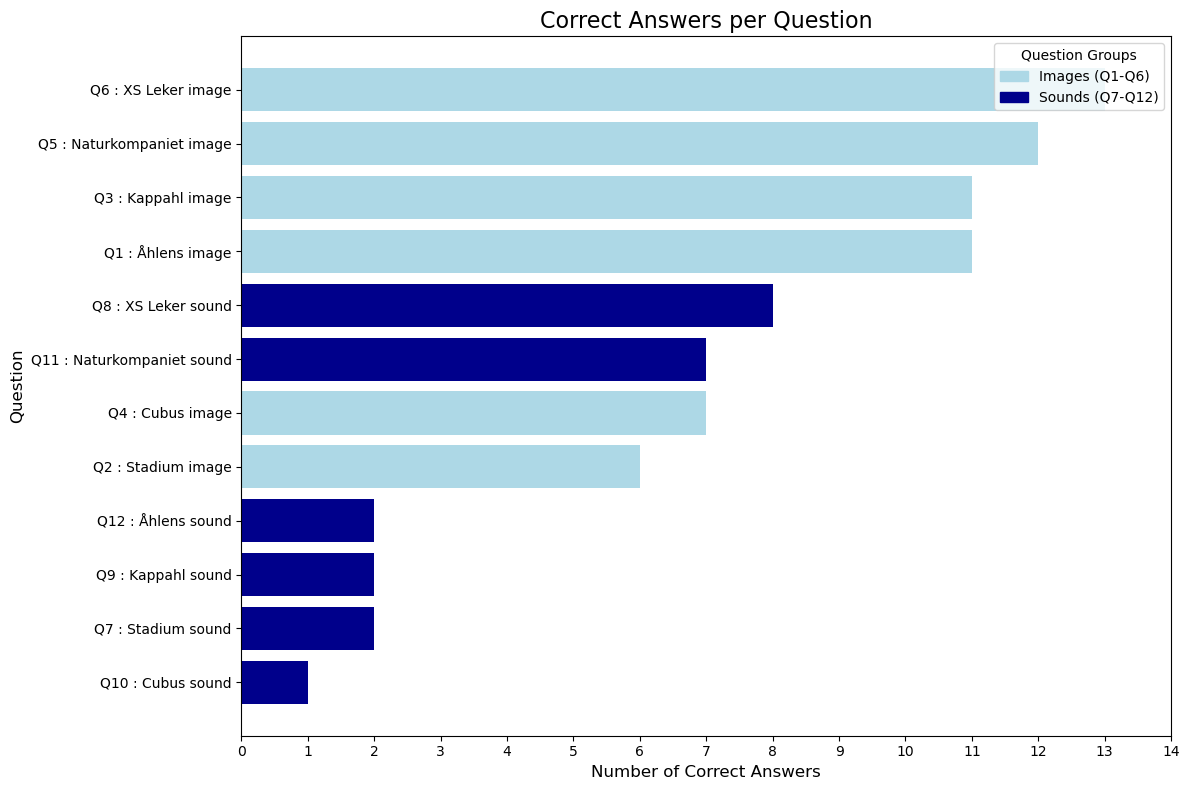

In [44]:
def plot_correct_answers(total_correct_per_question, correct_answers_dict, output_dir='plots/quiz'):
    # Create directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
      
    # Convert Series to DataFrame and rename columns
    correct_answers_df = total_correct_per_question.reset_index()
    correct_answers_df.columns = ['Questions', 'CorrectAnswers']
    correct_answers_df = correct_answers_df.sort_values(by='CorrectAnswers', ascending=True)
    
    # Create detailed labels combining question number and description
    detailed_labels = [f"{q} : {correct_answers_dict[q]}" for q in correct_answers_df['Questions']]
    
    # Define colors based on question groups (images vs sounds)
    colors = ['lightblue' if q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6'] else 'darkblue' 
              for q in correct_answers_df['Questions']]
    
    # Create figure with adjusted size to accommodate longer labels
    plt.figure(figsize=(12, 8))
    
    # Create horizontal bar plot
    plt.barh(range(len(detailed_labels)), correct_answers_df['CorrectAnswers'], color=colors)
    
    # Set the y-tick positions and labels
    plt.yticks(range(len(detailed_labels)), detailed_labels)
    
    plt.title('Correct Answers per Question', fontsize=16)
    plt.xlabel('Number of Correct Answers', fontsize=12)
    plt.ylabel('Question', fontsize=12)
    
    # Set x-axis ticks to integers
    plt.xticks(range(0, correct_answers_df['CorrectAnswers'].max() + 2))
    
    # Add legend
    legend_handles = [
        patches.Patch(color='lightblue', label='Images (Q1-Q6)'),
        patches.Patch(color='darkblue', label='Sounds (Q7-Q12)')
    ]
    plt.legend(handles=legend_handles, title='Question Groups', loc='upper right')
    
    # Adjust layout and save
    plt.tight_layout()
    filename = f"{output_dir}/corrects.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()


plot_correct_answers(total_correct_per_question, correct_answers_dict)

# Omnibus testing for images resp sounds 
Answers the question: are there significant differences in the difficulty level of the questions?

- Null Hypothesis: All questions have the same proportion of correct (positive) responses.
- Alternative Hypothesis: At least one question differs from the others in terms of the proportion of correct responses.


The Q statistic measures the overall variability in the proportions of positive responses across the groups.
A larger Q statistic indicates greater variability. 

Please note that although the data is coded as right or wrong, the actual ratio is not really 50%. Correct option is only 1/6! In short, the 1:5 ratio of correct to incorrect options doesn’t impact the binary setup of Cochran’s Q test but does affect the baseline expectation for correct answers if guessing is assumed. You can use Cochran’s Q to explore consistency across questions, and if needed, conduct additional analyses to examine how actual correctness rates align with guessing probability. If one wants to directly test whether the observed proportion of correct answers differs from random guessing across all questions, you might also consider a binomial test or chi-square goodness-of-fit test for each question individually. This would check whether the proportion of correct answers per question differs significantly from 16.67%, which represents random guessing. 


In [42]:
question_df
#question_df[['Q' + str(i) for i in range(7, 13)]]

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,1,0,1,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,1,0,0,0,0,1,0
5,1,1,1,1,1,1,0,0,0,0,0,0
6,1,1,1,1,1,1,0,1,0,0,0,0
7,1,0,1,0,1,1,0,1,1,0,1,0
8,0,0,1,1,1,1,0,1,0,0,0,0
9,0,0,1,1,1,0,0,0,0,1,1,0


In [43]:
# if these are different it is more likely there is a sig difference
question_df.mean()

Q1     0.611111
Q2     0.333333
Q3     0.611111
Q4     0.388889
Q5     0.666667
Q6     0.722222
Q7     0.111111
Q8     0.444444
Q9     0.111111
Q10    0.055556
Q11    0.388889
Q12    0.111111
dtype: float64

In [44]:
def perform_cochran_q_test(data):
    """
    Performs Cochran's Q test on the given data.

    Args:
        data (pandas.DataFrame): The DataFrame containing binary (0 or 1) data to be analyzed.

    Returns:
        None
    """

    # Ensure data is binary
    if not np.array_equal(data.values, data.values.astype(bool)):
        raise ValueError("Data must be binary (0 or 1) for Cochran's Q test.")

    # Perform Cochran's Q test directly on the values (no transpose needed)
    results = cochrans_q(data.values)
    q_statistic = results.statistic
    p_value = results.pvalue

    # Output results
    print(f"Cochran's Q Statistic: {q_statistic}")
    print(f"P-value: {p_value}")

    # Interpret the results
    if p_value < 0.05:
        print("Significant differences among the questions.")
    else:
        print("No significant differences among the questions.")

# Test all the data 
print('Testing all the questions regardless of image and sound condition.')
perform_cochran_q_test(question_df)
print('- - - - - - - - - - ')

# Test only image data 
print('Testing image conditions.')
perform_cochran_q_test(question_df[['Q' + str(i) for i in range(1, 7)]]) # Change everywhere else so that this is the standard syntax
print('- - - - - - - - - - ')

# Test only sound data 
print('Testing sound conditions.')
perform_cochran_q_test(question_df[['Q' + str(i) for i in range(7, 13)]]) 

Testing all the questions regardless of image and sound condition.
Cochran's Q Statistic: 50.46096654275093
P-value: 5.171148431757694e-07
Significant differences among the questions.
- - - - - - - - - - 
Testing image conditions.
Cochran's Q Statistic: 12.0
P-value: 0.03478778050624185
Significant differences among the questions.
- - - - - - - - - - 
Testing sound conditions.
Cochran's Q Statistic: 15.11111111111111
P-value: 0.009897979349433182
Significant differences among the questions.


In [ ]:
# Just to verify that crochan works, this should be significant
"""
myDf = pd.read_csv('FilmPreferences2123.csv')
myDf.head()
selData = myDf[['munt', 'movies', 'tuschin', 'arena']]
selData.head()
from statsmodels.stats.contingency_tables import cochrans_q
print(cochrans_q(selData))
# Should give 
#df          3
#pvalue      0.00022763307854354147
#statistic   19.384615384615383
"""

## Remember: The above test will not work when there is sparse data cause you cant divide by zero?

# Post hoc tests 
If significant results, continue with multiple comparison tests 


In [45]:
def add_significance_stars(p_value):
    """Add significance stars based on p-value."""
    if pd.isna(p_value):
        return ''
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    return ''

def format_p_value(p_value):
    """Format p-value with stars."""
    if pd.isna(p_value):
        return ''
    stars = add_significance_stars(p_value)
    if p_value < 0.001:
        return f"<0.001{stars}"
    return f"{p_value:.4f}{stars}"

def perform_pairwise_mcnemar(df):
    """
    Perform pairwise McNemar tests between all columns in the dataframe.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing binary (0/1) responses
    
    Returns:
    pandas.DataFrame: Matrix of formatted p-values from McNemar tests with significance stars
    pandas.DataFrame: Matrix of test statistics
    """
    columns = df.columns
    n_cols = len(columns)
    
    # Initialize results matrices
    p_values_raw = pd.DataFrame(np.nan, index=columns, columns=columns)
    p_values_formatted = pd.DataFrame('', index=columns, columns=columns)
    test_stats = pd.DataFrame(np.nan, index=columns, columns=columns)
    
    # Perform McNemar test for each pair of columns
    for i in range(n_cols):
        for j in range(i+1, n_cols):
            col1 = columns[i]
            col2 = columns[j]
            
            # Create contingency table
            contingency = pd.crosstab(df[col1], df[col2])
            
            # Check if we have enough unique values for McNemar test
            if contingency.shape != (2, 2):
                print(f"Warning: Cannot compute McNemar test for {col1} vs {col2} - insufficient variation in responses")
                continue
                
            try:
                # Perform McNemar test
                result = mcnemar(contingency, exact=True)
                
                # Store raw p-values for both directions
                p_values_raw.loc[col1, col2] = result.pvalue
                p_values_raw.loc[col2, col1] = result.pvalue
                
                # Store formatted p-values with stars for both directions
                formatted_p = format_p_value(result.pvalue)
                p_values_formatted.loc[col1, col2] = formatted_p
                p_values_formatted.loc[col2, col1] = formatted_p
                
                # Store test statistics for both directions
                test_stats.loc[col1, col2] = result.statistic
                test_stats.loc[col2, col1] = result.statistic
                
            except Exception as e:
                print(f"Warning: Could not compute McNemar test for {col1} vs {col2} - {str(e)}")
    
    return p_values_raw, p_values_formatted, test_stats

In [ ]:
"""
# Create test dataset with known differences to test 
n_samples = 100
np.random.seed(42)

test_df = pd.DataFrame({
    'A': np.random.binomial(1, 0.5, n_samples),  # 50% success rate
    'B': np.random.binomial(1, 0.5, n_samples),  # 50% success rate
    'C': np.random.binomial(1, 0.8, n_samples),  # 80% success rate
    'D': np.random.binomial(1, 0.2, n_samples)   # 20% success rate
})

# Make B dependent on A but with some changes
test_df['B'] = test_df['A'].copy()
flip_indices = np.random.choice(n_samples, 20, replace=False)
test_df.loc[flip_indices, 'B'] = 1 - test_df.loc[flip_indices, 'B']

print("Sample sizes and success rates:")
print(test_df.mean().round(3))
"""

In [46]:
print("\nMean values per column:")
print(question_df.mean())
p_values_raw, p_values_formatted, test_stats = perform_pairwise_mcnemar(question_df)

print("\nMcNemar Test P-values (with significance stars):")
print(p_values_formatted)
print("* p < 0.05, ** p < 0.01, *** p < 0.001")

print("\nMcNemar Test Statistics:")
print(test_stats)


Mean values per column:
Q1     0.611111
Q2     0.333333
Q3     0.611111
Q4     0.388889
Q5     0.666667
Q6     0.722222
Q7     0.111111
Q8     0.444444
Q9     0.111111
Q10    0.055556
Q11    0.388889
Q12    0.111111
dtype: float64

McNemar Test P-values (with significance stars):
           Q1       Q2        Q3       Q4         Q5         Q6        Q7  \
Q1              0.0625    1.0000   0.3877     1.0000     0.6250   0.0225*   
Q2     0.0625             0.0625   1.0000     0.0703    0.0156*    0.2891   
Q3     1.0000   0.0625             0.2188     1.0000     0.6875   0.0225*   
Q4     0.3877   1.0000    0.2188              0.1250     0.1094    0.1250   
Q5     1.0000   0.0703    1.0000   0.1250                1.0000   0.0129*   
Q6     0.6250  0.0156*    0.6875   0.1094     1.0000             0.0034**   
Q7    0.0225*   0.2891   0.0225*   0.1250    0.0129*   0.0034**             
Q8     0.4531   0.7266    0.4531   1.0000     0.2188     0.1250    0.1094   
Q9    0.0117*   0.2891   

In [ ]:
# Probably only makes sense to compare within sound and image categories 

# Q1 and Q7, 9, 10, 12
# Q2 and Q6
# Q3 and Q7, Q9, Q10, Q12
# Q4 and Q10
# Q5 and Q7, Q9, Q10, Q12 
# Q6 and Q2, Q7, Q9, Q10, Q12 
# Q7 and 3,5,6, .....

Reporting a McNemar test: 
A McNemar's test was conducted to compare the proportions of correct responses between the two groups. The results indicated a significant difference, χ²(1) = [Chi-square value], p = [p-value]. The odds ratio was [odds ratio], indicating that the odds of [event] were [times] higher in Group A compared to Group B.

# To be sure, also conduct a chi-square test for each question, to see if it is likely that the results are by chance. 

In [47]:
# Here we need the actual data, not coded by correct or incorrect 
df.head()
#df['Q1']

,Date,Session,Voter,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
0,2024-11-05,1,1,Åhlens,Naturkompaniet,XS Leker,Kappahl,Stadium,Cubus,Naturkompaniet,NaN,NaN,NaN,NaN,NaN
1,2024-11-05,2,2,Naturkompaniet,XS Leker,Stadium,Åhlens,Cubus,Kappahl,Stadium,Kappahl,XS Leker,Stadium,Naturkompaniet,Kappahl
2,2024-11-05,2,3,Kappahl,NaN,Stadium,Cubus,Åhlens,XS Leker,Stadium,Cubus,Kappahl,XS Leker,Åhlens,Stadium
3,2024-11-05,2,4,Kappahl,Naturkompaniet,XS Leker,Stadium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-11-06,3,5,Åhlens,Kappahl,Åhlens,Åhlens,Naturkompaniet,XS Leker,Cubus,Cubus,Naturkompaniet,Åhlens,Naturkompaniet,Stadium


In [48]:
# Test data 
"""
# Set a seed for reproducibility
np.random.seed(42)

# Number of participants
num_participants = 100

# Create a DataFrame with 12 questions
data = {
    'Q1': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q2': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants, p=[0.1, 0.1, 0.1, 0.1, 0.1, 0.5]),  # Bias towards 'F'
    'Q3': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q4': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q5': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q6': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q7': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q8': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q9': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q10': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q11': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q12': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants)
}

df_test_chisquare = pd.DataFrame(data)
df_test_chisquare
"""

"\n# Set a seed for reproducibility\nnp.random.seed(42)\n\n# Number of participants\nnum_participants = 100\n\n# Create a DataFrame with 12 questions\ndata = {\n    'Q1': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),\n    'Q2': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants, p=[0.1, 0.1, 0.1, 0.1, 0.1, 0.5]),  # Bias towards 'F'\n    'Q3': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),\n    'Q4': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),\n    'Q5': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),\n    'Q6': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),\n    'Q7': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),\n    'Q8': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),\n    'Q9': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),\n    'Q10': np.random.choice([

In [ ]:
df

In [49]:
def perform_chi2_test(df, column_name):
    """
    Performs a Chi-Square Goodness of Fit test on the specified column.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to test.

    Returns:
        None
    """

    observed_frequencies = df[column_name].value_counts().values
    total_observations = len(df)
    num_categories = len(observed_frequencies)
    expected_frequency = total_observations / num_categories
    expected_frequencies = [expected_frequency] * num_categories

    chi2, p_value, dof, _ = chi2_contingency([observed_frequencies, expected_frequencies])

    print(f"Chi-Square Test for {column_name}")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")

    if p_value < 0.05:
        print(f"******Significant difference detected for {column_name}.******")
    else:
        print(f"No significant difference detected for {column_name}.")

for col in df.columns[3:]:  # Assuming columns Q1 to Q12 start at index 3
    print('\n')
    perform_chi2_test(df, col)



Chi-Square Test for Q1
Chi-square statistic: 7.2015
p-value: 0.1256
Degrees of freedom: 4
No significant difference detected for Q1.


Chi-Square Test for Q2
Chi-square statistic: 4.1685
p-value: 0.3837
Degrees of freedom: 4
No significant difference detected for Q2.


Chi-Square Test for Q3
Chi-square statistic: 7.9714
p-value: 0.1578
Degrees of freedom: 5
No significant difference detected for Q3.


Chi-Square Test for Q4
Chi-square statistic: 2.8234
p-value: 0.4197
Degrees of freedom: 3
No significant difference detected for Q4.


Chi-Square Test for Q5
Chi-square statistic: 9.3680
p-value: 0.0525
Degrees of freedom: 4
No significant difference detected for Q5.


Chi-Square Test for Q6
Chi-square statistic: 9.5239
p-value: 0.0231
Degrees of freedom: 3
******Significant difference detected for Q6.******


Chi-Square Test for Q7
Chi-square statistic: 4.4942
p-value: 0.3432
Degrees of freedom: 4
No significant difference detected for Q7.


Chi-Square Test for Q8
Chi-square statistic:

# Old code below

## For testing, generate random numbers if there are n participants 

In [ ]:
# Define number of participants 
# This can also be used later for power calculations 
participants = hf.get_user_input()
print(f"The number of participants is: {participants}")

In [ ]:
# Define columns and create an empty DataFrame
columns = ['A', 'B', 'C', 'D', 'E', 'F']  # Answers for each question
index = [f'Q{i+1}' for i in range(6)]  # Questions Q1 to Q6
df = pd.DataFrame(columns=columns, index=index)
#hf.input_data(index, columns)
df.loc['Q1'] = [0, 1, 1, 1, 0, 2]  # Replace with actual values for Q1 etc
df.loc['Q2'] = [1, 0, 1, 1, 0, 2]  
df.loc['Q3'] = [1, 0, 1, 1, 0, 2]  
df.loc['Q4'] = [0, 0, 2, 1, 0, 2]  
df.loc['Q5'] = [0, 0, 0, 3, 0, 2]  
df.loc['Q6'] = [0, 0, 5, 0, 0, 0]  

In [ ]:
# Set random seed for reproducibility
np.random.seed(0)

# Define the indices and columns
row_indices = [f'Q{i}' for i in range(1, 7)]
columns = ['A', 'B', 'C', 'D', 'E', 'F']

# Initialize an empty DataFrame
df = pd.DataFrame(index=row_indices, columns=columns)

# Fill the DataFrame with random integers such that the sum of each row equals 5
for row in row_indices:
    # Generate random integers that sum to n participants
    values = np.random.multinomial(participants, [1/6]*6)
    # Assign to the DataFrame
    df.loc[row] = values

In [ ]:
# Display the DataFrame that we are working with (inputted data or generated)
print(df)

## Select question row and plot results

In [ ]:
#Observed counts for each option A-F in question Q1
observed_counts = df.loc['Q6']
# Calculate the total number of responses
total_responses = sum(observed_counts)

In [ ]:
# Plot data 
# Convert the Series to a dictionary
data = observed_counts.to_dict()

# Plotting the data
plt.figure(figsize=(8, 6))
pd.Series(data).plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Response Counts for Each Category (A-F) for Q1')
plt.xticks(rotation=0)
# Set y-axis limit to the total number of replies
plt.ylim(0, total_responses)  # Set the y-axis limits
# Optionally, you can add a horizontal line at the total responses for clarity
plt.show()

## Chi-Square Goodness of Fit Test for Separate Questions
Tests whether the observed frequencies of a single categorical variable match expected frequencies under a specific hypothesis.

Hypothesis:
- Null Hypothesis (H₀): The observed distribution matches the expected distribution.
- Alternative Hypothesis (H₁): The observed distribution does not match the expected distribution.

The Chi-Square Goodness of Fit Test compares the observed distribution of responses to a uniform distribution, assuming that each answer choice (A-F) has an equal probability of being selected if participants are choosing randomly.

### Manual calculation

In [ ]:
# Calculate the expected counts assuming each option is equally likely
expected_count = total_responses / 6
expected_counts = [expected_count] * 6

# Calculate the Chi-Square statistic by hand
chi_square_stat = sum(
    ((observed - expected) ** 2) / expected
    for observed, expected in zip(observed_counts, expected_counts)
)

# Print the calculated Chi-Square statistic
print("Chi-Square Statistic (calculated manually):", chi_square_stat)

# Degrees of freedom for this test
deg_freedom = len(observed_counts) - 1  # Here, df = 6 - 1 = 5

# To determine the significance level, we typically need a p-value.
# To fully implement this, we’d need to calculate or look up the critical value in a Chi-Square table.
# Example:
# For df=5 and significance level 0.05, the critical value is approximately 11.07
# So, we can interpret by comparing:

critical_value_95 = 11.07

# Calculate the p-value using the Chi-Square survival function
p_value = gammaincc(deg_freedom / 2, chi_square_stat / 2)
print("P-value: ", p_value)

#if chi_square_stat > critical_value_95:
if p_value < 0.05:
    print("The result is statistically significant at the 0.05 level.")
    print("The observed distribution of responses is significantly different from random guessing.")
else:
    print("The result is not statistically significant at the 0.05 level.")
    print("The observed distribution of responses is consistent with random guessing.")

### Using scipy.stats package

In [ ]:
# Calculate the total number of responses for Q1
total_responses = sum(observed_counts)

# Expected counts assuming equal probability for each option (random guessing)
expected_count = total_responses / 6
expected_counts = [expected_count] * 6

# Perform the Chi-Square Goodness of Fit test
chi2_stat, p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)

# Output the results
print("Total number of responses:", total_responses)
print("Chi-Square Statistic:", chi2_stat) # How much the observed counts differ from the expected counts. Higher values indicate larger deviations.
print("p-value:", p_value) # A low p-valu, it suggests that the distribution of responses in Q1 is not likely to be due to random guessing, and some options may be selected more often than expected by chance.

# Interpretation of results
if p_value < 0.05:
    print(f"The p-value is {p_value:.4f}. This is less than the significance level of 0.05.")
    print("We reject the null hypothesis, suggesting that the observed distribution of responses for question Q1")
    print("is significantly different from what would be expected by random guessing. Some answer options may be chosen more often.")
else:
    print(f"The p-value is {p_value:.4f}. This is greater than the significance level of 0.05.")
    print("We do not reject the null hypothesis, indicating that the observed distribution of responses for question Q1")
    print("is not significantly different from random guessing. The responses appear consistent with chance.")

## Crochan Q test for omnibus testing

In [ ]:
# Specify correct answers for each question
correct_answers = {
    'Q1': 'A',
    'Q2': 'C',
    'Q3': 'D',
    'Q4': 'F',
    'Q5': 'A',
    'Q6': 'B'
}

## Generate sample data to test 

In [ ]:
# Each row is a participant, each column is their answer to that question
participant_responses = pd.DataFrame({
    'Q1': ['B', 'A', 'C', 'F', 'D'],  # what each participant answered for Q1
    'Q2': ['C', 'C', 'B', 'A', 'F'],  # ... Q2 and so on 
    'Q3': ['D', 'D', 'D', 'C', 'A'],  
    'Q4': ['F', 'F', 'F', 'D', 'B'],  
    'Q5': ['A', 'C', 'D', 'A', 'E'],  
    'Q6': ['B', 'B', 'C', 'B', 'D']   
})

participant_responses

In [ ]:
def convert_to_binary(responses, correct_answers):
    """
    Convert participant responses to binary format (1 for correct, 0 for incorrect)
    
    Parameters:
    responses (pd.DataFrame): DataFrame where each row is a participant and each column is their answer
    correct_answers (dict): Dictionary mapping question number to correct answer
    
    Returns:
    pd.DataFrame: Binary DataFrame where 1 indicates correct answer, 0 indicates incorrect
    """
    binary_df = pd.DataFrame(index=responses.index, columns=responses.columns)
    
    for question in responses.columns:
        binary_df[question] = (responses[question] == correct_answers[question]).astype(int)
    
    return binary_df

binary_responses = convert_to_binary(participant_responses, correct_answers)
print(binary_responses)
print(correct_answers)

In [ ]:
# Print original responses and binary format
print("Original participant responses:")
print(participant_responses)
print("\nBinary format (1 = correct, 0 = incorrect):")
print(binary_responses)

# Let's also see how each participant did overall
print("\nTotal correct answers per participant:")
print(binary_responses.sum(axis=1))

# And how many got each question right
print("\nNumber of correct answers per question:")
print(binary_responses.sum(axis=0))

print("\nSuccess rate for each question:")
print(binary_responses.mean() * 100)  # Percentage correct for each question

In [ ]:
# Test whether the questions have significantly different levels of difficulty.  
# Compare how the same participants performed across all questions.

In [ ]:
binary_responses

In [ ]:
# Test whether the questions have significantly different levels of difficulty.  
# Compare how the same participants performed across all questions.

# Transpose the DataFrame to get the required input format
data_for_cochrans_q = binary_responses.T.values  # Transpose to get questions as rows
print(data_for_cochrans_q)

# Calculate Crochan's Q
results = cochrans_q(data_for_cochrans_q)

# Access the Q statistic and p-value
q_statistic = results.statistic
p_value = results.pvalue

print(f"Cochran's Q Statistic: {q_statistic}")
print(f"P-value: {p_value}")

In [ ]:
# Interpretation 

# Interpretation based on Cochran's Q and p-value
if p_value < 0.05:
    print("The p-value is less than 0.05, indicating significant differences among the questions.")
    if q_statistic > 0:
        print(f"Cochran's Q Statistic: {q_statistic} suggests that there is variability in responses.")
        print("At least one question differs significantly from the others in the proportion of correct answers.")
else:
    print("The p-value is greater than or equal to 0.05, indicating no significant differences among the questions.")
    print(f"Cochran's Q Statistic: {q_statistic} indicates that the responses are relatively uniform across questions.")

# It would be nice with a confusion matrix 